## Assignment2

In [1]:
import collections
import time
import pandas as pd
import numpy as np
import re
import html
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import TruncatedSVD, PCA, IncrementalPCA
from sklearn.metrics import classification_report

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liuweilin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 0. Load Data

In [2]:
twitter_file = 'Sentiment.csv'
election_file = 'Canadian_elections_2019.csv'
twitter_df = pd.read_csv(twitter_file, dtype={'text':'str'})
election_df = pd.read_csv(election_file, dtype={'text':'str', 'negative_reason':'str'})

In [3]:
print('twitter data shape: ', twitter_df.shape)
twitter_df.head()

twitter data shape:  (133811, 2)


,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...


In [4]:
print('Canadian elections data shape: ', election_df.shape)
election_df.head()

Canadian elections data shape:  (2133, 3)


,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


### 1. Data Cleaning

In [5]:
# drop rows with null sentiment or null text
twitter_df.dropna(subset=['sentiment', 'text'], inplace=True)
twitter_df = twitter_df[twitter_df['sentiment'] != 'Neutral']
print('twitter data shape: ', twitter_df.shape)
election_df.dropna(subset=['sentiment', 'text'], inplace=True)
print('Canadian elections data shape: ', election_df.shape)

twitter data shape:  (130655, 2)
Canadian elections data shape:  (2133, 3)


In [12]:
hashtags = []
html_tag_reg = re.compile(r'<[^>]+>')
url_reg = re.compile(r'https?://?\S+')
# tokenizer = TweetTokenizer()
tokenizer = RegexpTokenizer(r'[@#]?\w+') # keep @ and #hashtag
# tokenizer = RegexpTokenizer(r'[#]?\w+') # keep #hashtag
stemmer = PorterStemmer()

def clean(raw):
    # remove html tags and attributes
    try:
        raw = html_tag_reg.sub('', raw)

        # replace html character codes with an ASCII equivalent
        # for example, &pound is replaced with £
        raw = html.unescape(raw)

        # remove Urls
        raw = url_reg.sub('', raw)

        # lowercase
        raw = raw.lower()

        # tokenize and remove stop words, stop words come from NLTK corpus
        words = tokenizer.tokenize(raw)
        # extract hashtags
        hashtag_arr = [word.strip('#') for word in words if re.match('^#', word)]
        # extract mentions
        mention_arr = [word.strip('@') for word in words if re.match('^@', word)]
        hashtags.append(' '.join(hashtag_arr))
        # remove characters matching [^a-zA-Z0-9_]
        # words = [re.sub('\W+', '', word) for word in words]
        # choose characters containing only alphabets
        words = [word for word in words if not re.search('\W+', word)]
        # remove stop words
        words_rmStop = [word.strip() for word in words if word not in stopwords.words('english')]
        # stem
        words_rmStop = [stemmer.stem(word) for word in words_rmStop]
        return ' '.join(words_rmStop + hashtag_arr + mention_arr)
    except Exception as e:
        print('error: ', e)
        print(raw)
        return ' '
print(clean("ff^^ #ff90 @ff1 ff, ff."))
print(hashtags)
re.sub('\W+', '', "@few.")
print(not re.search('[^a-z]+', "ff33"))

ff ff ff ff90 ff1
['ff90']
False


In [13]:
hashtags = []
twitter_df['text'] = twitter_df['text'].apply(clean)
print('twitter clean done')
print('twitter data shape: ', twitter_df.shape)
print('twitter hashtags size: ', len(hashtags))
twitter_df['hashtag'] = hashtags
print('clean twitter data shape: ', twitter_df.shape)

twitter clean done
twitter data shape:  (130655, 2)
twitter hashtags size:  130655
clean twitter data shape:  (130655, 3)


In [14]:
hashtags = []
election_df['text'] = election_df['text'].apply(clean)
print('election clean done')
print('election data shape: ', election_df.shape)
print('election hashtags size: ', len(hashtags))
election_df['hashtag'] = hashtags
print('clean election data shape: ', election_df.shape)

election clean done
election data shape:  (2133, 3)
election hashtags size:  2133
clean election data shape:  (2133, 4)


In [15]:
# format sentiment
sentiment_dt = {
    'Negative': -1,
    # 'Neutral': 0,
    'Positive': 1
}
print(twitter_df['sentiment'].unique())
print(election_df['sentiment'].unique())
twitter_df['sentiment'] = twitter_df['sentiment'].apply(lambda x:sentiment_dt[x])
election_df['sentiment'] = election_df['sentiment'].apply(lambda x:sentiment_dt[x])
print(twitter_df['sentiment'].unique())
print(election_df['sentiment'].unique())

['Positive' 'Negative']
['Negative' 'Positive']
[ 1 -1]
[-1  1]


In [16]:
twitter_df.to_csv('twitter.csv', index = False)
election_df.to_csv('election.csv', index = False)

In [1]:
import collections
import time
import pandas as pd
import numpy as np
import re
import html
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import TruncatedSVD, PCA, IncrementalPCA
from sklearn.metrics import classification_report

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

twitter_df = pd.read_csv('twitter.csv')
twitter_df.hashtag = twitter_df.hashtag.fillna('')
twitter_df.text = twitter_df.text.fillna('')
# print(twitter_df['sentiment'].unique())
election_df = pd.read_csv('election.csv')
election_df.hashtag = election_df.hashtag.fillna('')
election_df.text = election_df.text.fillna('')
# print(election_df['sentiment'].unique())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liuweilin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2. Exploratory analysis

#### 2.1 Polical parties
Determine the political party(Liberal, Conservative, NDP, None) in the tweets in the 2019 Canadian elections datasets

In [2]:
stemmer = PorterStemmer()
party_dict = {
    stemmer.stem('NDP'): 'NDP',
    stemmer.stem('Conservative'): 'Conservative',
    stemmer.stem('Liberal'): 'Liberal', 
}

def identify_party(words):
    party = "None"
    for word in words.split(' '):
        root = stemmer.stem(word)
        if root in party_dict:
            party = party_dict[root]
            break
    parties.append(party)

In [3]:
parties = []
election_df['text'].apply(identify_party)
election_df['party'] = parties

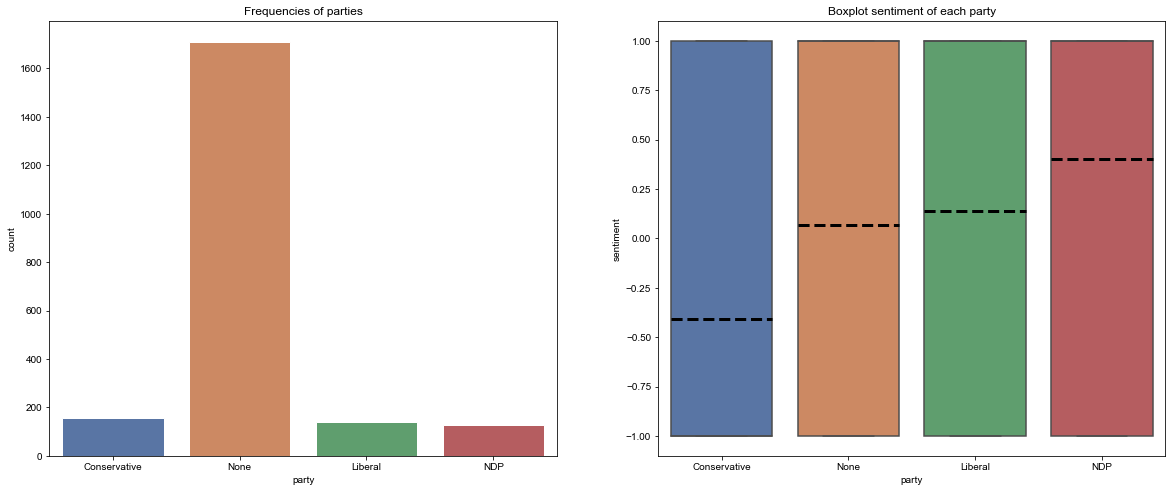

In [4]:
parties = ['Conservative', 'Liberal', 'NOP', 'None']
fig, axes = plt.subplots(1,2,figsize=(20,8))
# frequecies of parties mentioned
sns.set(style="darkgrid")
sns.countplot(x='party', label=parties, data=election_df, ax=axes[0]).set_title('Frequencies of parties')
# average sentiment of parties
sns.boxplot(x=election_df['party'], 
            y=election_df['sentiment'].astype('float'), 
            ax=axes[1], 
            # color='white',
            showmeans=True, 
            meanline=True,
            meanprops=dict(linestyle='--', linewidth=3, color='black')).set_title('Boxplot sentiment of each party')
# ax = sns.boxplot(x=election_df["sentiment"], showmeans=True)
plt.show()

We found the numbers of Conservative, Liberal and NDP are almost the same. While most most do not have a specific party mentioned in their twitter. In the same time, the NDP has the most positive twitter sentiment and Conservativ has the most negative twitter sentiment.

#### 2.2 Distributions of hashtags in Sentiment.csv

In [5]:
twitter_hashtag_count = collections.defaultdict(int)

def word_freq(hashtags):
    for h in hashtags.split(' '):
        if len(h):
            twitter_hashtag_count[h] += 1
        
twitter_df['hashtag'].apply(word_freq)
print('Number of hashtags: ', len(twitter_hashtag_count.keys()))

Number of hashtags:  2773


['foxdebate', 'trump2016', 'blacklivesmatter', 'gopdâ', 'kkkorgop', 'f1', 'donaldtrump', 'â', 'fb', 'foxnews', 'tedcruz', 'gop', 'gopdebatâ', 'gopdebateâ', 'gâ', 'trump', 'tcot', 'asot400', 'gopdebates', 'gopdebate']


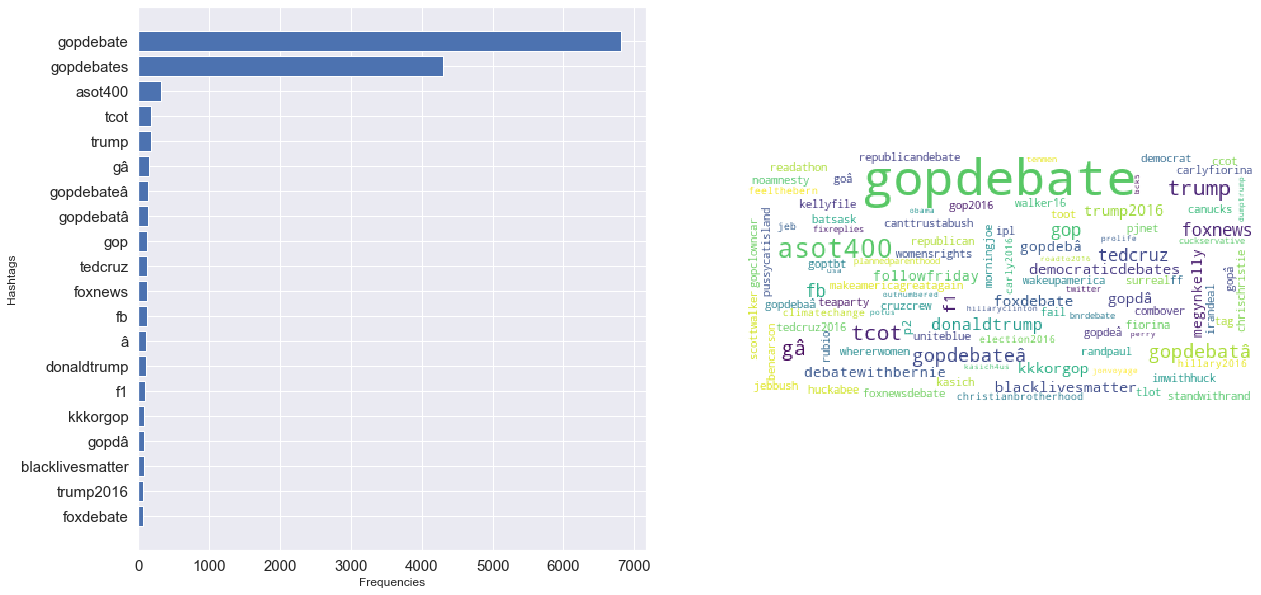

In [6]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
fig, axes = plt.subplots(1,2,figsize=(20,10))
# bar plot of top mentioned hashtags
top = 20
hashtags_sorted = sorted(twitter_hashtag_count.keys(), key=lambda x:twitter_hashtag_count[x], reverse=True)[:top][::-1]
axes[0].barh(hashtags_sorted, [twitter_hashtag_count[x] for x in hashtags_sorted])
axes[0].set_xlabel('Frequencies')
axes[0].set_ylabel('Hashtags')
print(hashtags_sorted)
# word cloud
wcloud = WordCloud(background_color='white',
                   stopwords=[],
                   max_words=100,
                   max_font_size=40,
                   random_state=42,
                   collocations=False,
                  ).generate(' '.join(twitter_df['hashtag'].values))
axes[1].imshow(wcloud)
axes[1].axis('off')
plt.show()

We found twitters in Sentiment.csv are closely related to gopdebate, which stands for GOP debate in United States.

#### 2.3 Distributions of words in negative_reason in 2019 Canadian election tweets

11
Women Reproductive right and Racism
nan
Economy
Others
Scandal
Tell lies
Privilege
Climate Problem
Healthcare
Separation
Healthcare and Marijuana


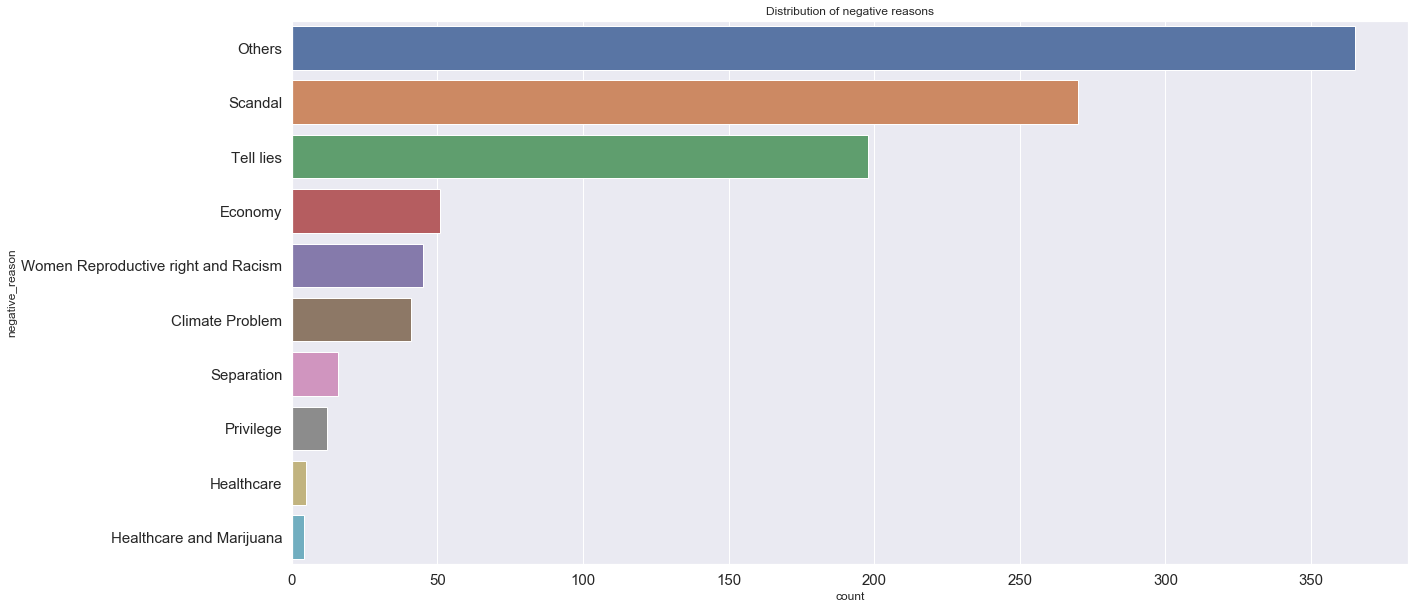

In [7]:
print(len(election_df['negative_reason'].unique()))
for reason in election_df['negative_reason'].unique():
    print(reason)
fig, ax = plt.subplots(figsize=(20,10))
sns.set(style="darkgrid")
ax = sns.countplot(y='negative_reason', 
                   order=election_df['negative_reason'].value_counts().index, 
                   data=election_df)
ax.set_title("Distribution of negative reasons")
plt.show()

### 3. Model preparation

In [8]:
columns = ['text', 'sentiment']
twitter_train, twitter_test = train_test_split(twitter_df[columns].values, test_size=0.3, random_state=42)
print(type(twitter_train), twitter_train.shape)
print(type(twitter_test), twitter_test.shape)

<class 'numpy.ndarray'> (91458, 2)
<class 'numpy.ndarray'> (39197, 2)


In [9]:
np.random.shuffle(twitter_train)
twitter_train_X, twitter_train_y = twitter_train[:,[0]], twitter_train[:, [1]]
twitter_train_X, twitter_train_y = twitter_train_X.flatten(), twitter_train_y.flatten().astype('int')
print(twitter_train_X.shape)
print(twitter_train_y.shape)

twitter_test_X, twitter_test_y = twitter_test[:,[0]], twitter_test[:, [1]]
twitter_test_X, twitter_test_y = twitter_test_X.flatten(), twitter_test_y.flatten().astype('int')
print(twitter_test_X.shape)
print(twitter_test_y.shape)

(91458,)
(91458,)
(39197,)
(39197,)


**WF, Word Frequency as feature**

In [10]:
components = 100
# pca = PCA(n_components=components, random_state=42)
# pca = PCA(n_components=components)

# vectorizer_wf = CountVectorizer(min_df=0.001, max_df=0.999)
vectorizer_wf = CountVectorizer(max_features=200)
twitter_train_X_WF = vectorizer_wf.fit_transform(twitter_train_X).toarray()
# print(vectorizer_wf.vocabulary_)
print(vectorizer_wf.get_feature_names()[:50])
print(twitter_train_X_WF.shape)
# twitter_train_X_WF = pca.fit_transform(twitter_train_X_WF)
# print(twitter_train_X_WF.shape)

twitter_test_X_WF = vectorizer_wf.transform(twitter_test_X).toarray()
# twitter_test_X_WF = pca.fit_transform(twitter_test_X_WF)
print(twitter_test_X_WF.shape)

['actual', 'alreadi', 'alway', 'amaz', 'anoth', 'ask', 'away', 'awesom', 'back', 'bad', 'beauti', 'bed', 'best', 'better', 'big', 'bit', 'bore', 'call', 'candid', 'cant', 'check', 'cold', 'come', 'cool', 'could', 'damn', 'day', 'debat', 'done', 'dont', 'earli', 'eat', 'end', 'enjoy', 'even', 'ever', 'everyon', 'feel', 'final', 'find', 'finish', 'first', 'follow', 'fox', 'friend', 'fuck', 'fun', 'game', 'get', 'girl']
(91458, 200)
(39197, 200)


**TF-IDF, as feature**

In [11]:
# vectorizer_tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, min_df=0.001, max_df=0.999)
vectorizer_tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=200)
twitter_train_X_TFIDF = vectorizer_tfidf.fit_transform(twitter_train_X).toarray()
print(twitter_train_X_TFIDF.shape)
# twitter_train_X_TFIDF = pca.fit_transform(twitter_train_X_TFIDF)
# print(vectorizer_tfidf.vocabulary_)
print(vectorizer_tfidf.get_feature_names()[:50])
print(twitter_train_X_TFIDF.shape)

twitter_test_X_TFIDF = vectorizer_tfidf.transform(twitter_test_X).toarray()
# twitter_test_X_TFIDF = pca.fit_transform(twitter_test_X_TFIDF)
print(twitter_test_X_TFIDF.shape)

(91458, 200)
['actual', 'alreadi', 'alway', 'amaz', 'anoth', 'ask', 'away', 'awesom', 'back', 'bad', 'beauti', 'bed', 'best', 'better', 'big', 'bit', 'bore', 'call', 'candid', 'cant', 'check', 'cold', 'come', 'cool', 'could', 'damn', 'day', 'debat', 'done', 'dont', 'earli', 'eat', 'end', 'enjoy', 'even', 'ever', 'everyon', 'feel', 'final', 'find', 'finish', 'first', 'follow', 'fox', 'friend', 'fuck', 'fun', 'game', 'get', 'girl']
(91458, 200)
(39197, 200)


### 4. Model implementation
We train and compare the following models with WF and TF-IDF as features repectively:
* Logistic regression
* K-nearest neighbor
* Naive Bayes
* Linear SVM
* Decision Tree
* Random Forest
* Adaboost

We then choose the best model and evaluate on the 2019 Canadian Election Dataset.

#### 4.1 Logistic regression

In [12]:
import warnings
warnings.filterwarnings("ignore")

# Logistic regression
name = "Logistic regression"
# Set the parameters by cross-validation
score = 'accuracy'
tuned_parameters = {
    'C': [1, 10, 100],
    'solver': ['sag', 'saga']
}

clf11 = GridSearchCV(
    LogisticRegression(), tuned_parameters, scoring=score, cv=3
)
clf11.fit(twitter_train_X_WF, twitter_train_y)

print("Best parameters set found on development set:")
print(clf11.best_params_)
print("Grid scores on development set:")
means = clf11.cv_results_['mean_test_score']
stds = clf11.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf11.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf11.predict(twitter_test_X_WF)
print(classification_report(y_true, y_pred))

print('---------------------------')
clf12 = GridSearchCV(
    LogisticRegression(), tuned_parameters, scoring=score, cv=3
)
clf12.fit(twitter_train_X_TFIDF, twitter_train_y)

print("Best parameters set found on development set:")
print(clf12.best_params_)
print("Grid scores on development set:")
means = clf12.cv_results_['mean_test_score']
stds = clf12.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf12.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf12.predict(twitter_test_X_TFIDF)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'C': 1, 'solver': 'sag'}
Grid scores on development set:
0.694 (+/-0.006) for {'C': 1, 'solver': 'sag'}
0.694 (+/-0.006) for {'C': 1, 'solver': 'saga'}
0.694 (+/-0.006) for {'C': 10, 'solver': 'sag'}
0.694 (+/-0.006) for {'C': 10, 'solver': 'saga'}
0.694 (+/-0.006) for {'C': 100, 'solver': 'sag'}
0.694 (+/-0.006) for {'C': 100, 'solver': 'saga'}
Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.73      0.70      0.71     21330
           1       0.66      0.69      0.67     17867

    accuracy                           0.69     39197
   macro avg       0.69      0.69      0.69     39197
weighted avg       0.70      0.69      0.69     39197

---------------------------
Best parameters set found on development set:
{'C': 1, 'solver': 'sag'}
Grid scores on development set:
0.694 (+/-0.006) for {'C': 1, 'solver': 'sag'}
0.694 (+/-0.006) for {'C': 1, 'solver': 'saga'}
0.694 

#### 4.2 K-nearest neighbor

In [13]:
# K-nearest neighbor, without cross validation
name = "K-nearest neighbor"

clf21 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
clf21.fit(twitter_train_X_WF, twitter_train_y)

print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf21.predict(twitter_test_X_WF)
print(classification_report(y_true, y_pred))

print('-----------------------------------')

clf22 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
clf22.fit(twitter_train_X_TFIDF, twitter_train_y)

print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf22.predict(twitter_test_X_TFIDF)
print(classification_report(y_true, y_pred))

Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.69      0.62      0.65     21330
           1       0.59      0.66      0.63     17867

    accuracy                           0.64     39197
   macro avg       0.64      0.64      0.64     39197
weighted avg       0.64      0.64      0.64     39197

-----------------------------------
Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.65      0.71      0.68     21330
           1       0.61      0.55      0.58     17867

    accuracy                           0.64     39197
   macro avg       0.63      0.63      0.63     39197
weighted avg       0.63      0.64      0.63     39197



#### 4.3 Naive Bayes

In [21]:
# Naive Bayes
name = "Naive Bayes"

clf31 = GaussianNB()
clf31.fit(twitter_train_X_WF, twitter_train_y)
print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf31.predict(twitter_test_X_WF)
print(classification_report(y_true, y_pred))

print('-----------------------------------')

clf32 = GaussianNB()
clf32.fit(twitter_train_X_TFIDF, twitter_train_y)
print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf32.predict(twitter_test_X_TFIDF)
print(classification_report(y_true, y_pred))

Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.77      0.53      0.63     21330
           1       0.59      0.82      0.69     17867

    accuracy                           0.66     39197
   macro avg       0.68      0.67      0.66     39197
weighted avg       0.69      0.66      0.66     39197

-----------------------------------
Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.77      0.53      0.63     21330
           1       0.59      0.82      0.69     17867

    accuracy                           0.66     39197
   macro avg       0.68      0.67      0.66     39197
weighted avg       0.69      0.66      0.66     39197



#### 4.4 Linear SVM

In [15]:
# Linear SVM
name = "Linear SVM"
# Set the parameters by cross-validation
score = 'accuracy'
tuned_parameters = {
    # 'penalty': ['l1', 'l2'],
    'C': [1, 10]
}

clf41 = GridSearchCV(
    LinearSVC(), tuned_parameters, scoring=score, cv=3, n_jobs=-1
)
clf41.fit(twitter_train_X_WF, twitter_train_y)

print("Best parameters set found on development set:")
print(clf41.best_params_)
print("Grid scores on development set:")
means = clf41.cv_results_['mean_test_score']
stds = clf41.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf41.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf41.predict(twitter_test_X_WF)
print(classification_report(y_true, y_pred))

print('-----------------------------------')

clf42 = GridSearchCV(
    LinearSVC(), tuned_parameters, scoring=score, cv=3, n_jobs=-1
)
clf42.fit(twitter_train_X_TFIDF, twitter_train_y)

print("Best parameters set found on development set:")
print(clf42.best_params_)
print("Grid scores on development set:")
means = clf42.cv_results_['mean_test_score']
stds = clf42.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf42.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf42.predict(twitter_test_X_TFIDF)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'C': 10}
Grid scores on development set:
0.694 (+/-0.005) for {'C': 1}
0.694 (+/-0.006) for {'C': 10}
0.669 (+/-0.006) for {'C': 100}
Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.73      0.70      0.71     21330
           1       0.66      0.69      0.67     17867

    accuracy                           0.69     39197
   macro avg       0.69      0.69      0.69     39197
weighted avg       0.70      0.69      0.69     39197

-----------------------------------
Best parameters set found on development set:
{'C': 1}
Grid scores on development set:
0.694 (+/-0.004) for {'C': 1}
0.648 (+/-0.012) for {'C': 10}
0.607 (+/-0.041) for {'C': 100}
Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.73      0.70      0.71     21330
           1       0.66      0.69      0.67     17867

    accuracy          

#### 4.5 Decision Tree

In [16]:
# Decision Tree
name = "Decision Tree"
# Set the parameters by cross-validation
score = 'accuracy'
tuned_parameters = {
    'max_depth': [2,3,4]
}

clf51 = GridSearchCV(
    DecisionTreeClassifier(), tuned_parameters, scoring=score, cv=3
)
clf51.fit(twitter_train_X_WF, twitter_train_y)

print("Best parameters set found on development set:")
print(clf51.best_params_)
print("Grid scores on development set:")
means = clf51.cv_results_['mean_test_score']
stds = clf51.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf51.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf51.predict(twitter_test_X_WF)
print(classification_report(y_true, y_pred))

print('-----------------------------------')

clf52 = GridSearchCV(
    DecisionTreeClassifier(), tuned_parameters, scoring=score, cv=3
)
clf52.fit(twitter_train_X_TFIDF, twitter_train_y)

print("Best parameters set found on development set:")
print(clf52.best_params_)
print("Grid scores on development set:")
means = clf52.cv_results_['mean_test_score']
stds = clf52.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf52.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf52.predict(twitter_test_X_TFIDF)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'max_depth': 4}
Grid scores on development set:
0.570 (+/-0.001) for {'max_depth': 2}
0.570 (+/-0.002) for {'max_depth': 3}
0.571 (+/-0.001) for {'max_depth': 4}
Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.56      0.99      0.71     21330
           1       0.83      0.06      0.12     17867

    accuracy                           0.57     39197
   macro avg       0.69      0.53      0.41     39197
weighted avg       0.68      0.57      0.44     39197

-----------------------------------
Best parameters set found on development set:
{'max_depth': 4}
Grid scores on development set:
0.570 (+/-0.001) for {'max_depth': 2}
0.570 (+/-0.002) for {'max_depth': 3}
0.571 (+/-0.001) for {'max_depth': 4}
Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.56      0.99      0.71     21330
           1       0

#### 4.6 Random Forest

In [17]:
# Random Forest
name = "Random Forest"
# Set the parameters by cross-validation
score = 'accuracy'
tuned_parameters = {
    'max_depth': [2,3,4]
}

clf61 = GridSearchCV(
    RandomForestClassifier(), tuned_parameters, scoring=score, cv=3
)
clf61.fit(twitter_train_X_WF, twitter_train_y)

print("Best parameters set found on development set:")
print(clf61.best_params_)
print("Grid scores on development set:")
means = clf61.cv_results_['mean_test_score']
stds = clf61.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf61.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf61.predict(twitter_test_X_WF)
print(classification_report(y_true, y_pred))

clf62 = GridSearchCV(
    RandomForestClassifier(), tuned_parameters, scoring=score, cv=3
)
clf62.fit(twitter_train_X_TFIDF, twitter_train_y)

print("Best parameters set found on development set:")
print(clf62.best_params_)
print("Grid scores on development set:")
means = clf62.cv_results_['mean_test_score']
stds = clf62.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf62.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf62.predict(twitter_test_X_TFIDF)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'max_depth': 4}
Grid scores on development set:
0.568 (+/-0.011) for {'max_depth': 2}
0.578 (+/-0.025) for {'max_depth': 3}
0.585 (+/-0.014) for {'max_depth': 4}
Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.57      0.97      0.72     21330
           1       0.77      0.13      0.22     17867

    accuracy                           0.59     39197
   macro avg       0.67      0.55      0.47     39197
weighted avg       0.66      0.59      0.49     39197

Best parameters set found on development set:
{'max_depth': 4}
Grid scores on development set:
0.573 (+/-0.030) for {'max_depth': 2}
0.580 (+/-0.011) for {'max_depth': 3}
0.584 (+/-0.019) for {'max_depth': 4}
Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.57      0.96      0.72     21330
           1       0.75      0.15      0.26     17867

 

#### 4.7 Adaboost

In [18]:
# Adaboost
name = "Adaboost"
# Set the parameters by cross-validation
score = 'accuracy'
tuned_parameters = {
    'n_estimators': [10, 15, 20]
}

clf71 = GridSearchCV(
    AdaBoostClassifier(), tuned_parameters, scoring=score, cv=3
)
clf71.fit(twitter_train_X_WF, twitter_train_y)

print("Best parameters set found on development set:")
print(clf71.best_params_)
print("Grid scores on development set:")
means = clf71.cv_results_['mean_test_score']
stds = clf71.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf71.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf71.predict(twitter_test_X_WF)
print(classification_report(y_true, y_pred))

print('-----------------------------------')

clf72 = GridSearchCV(
    AdaBoostClassifier(), tuned_parameters, scoring=score, cv=3
)
clf72.fit(twitter_train_X_TFIDF, twitter_train_y)

print("Best parameters set found on development set:")
print(clf72.best_params_)
print("Grid scores on development set:")
means = clf72.cv_results_['mean_test_score']
stds = clf72.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf72.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print("Detailed classification report on Test data:")
y_true, y_pred = twitter_test_y, clf72.predict(twitter_test_X_TFIDF)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'n_estimators': 20}
Grid scores on development set:
0.604 (+/-0.007) for {'n_estimators': 10}
0.610 (+/-0.003) for {'n_estimators': 15}
0.621 (+/-0.010) for {'n_estimators': 20}
Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.80      0.42      0.55     21330
           1       0.56      0.88      0.68     17867

    accuracy                           0.63     39197
   macro avg       0.68      0.65      0.62     39197
weighted avg       0.69      0.63      0.61     39197

-----------------------------------
Best parameters set found on development set:
{'n_estimators': 20}
Grid scores on development set:
0.604 (+/-0.007) for {'n_estimators': 10}
0.610 (+/-0.003) for {'n_estimators': 15}
0.621 (+/-0.010) for {'n_estimators': 20}
Detailed classification report on Test data:
              precision    recall  f1-score   support

          -1       0.80      0.42      0.5

#### 4.8 Evaluate the Best Model on the 2019 Canadian elections data
Based on the classification report, **Linear SVM** with C=10, WF feature has the best performance of accuracy. Then we are going to evaluate the model(clf41) on the 2019 Canadian elections data. As is shown, our Linear SVM model could reach **0.54** of accuray, which is higher than the random guess.

In [24]:
election_X, election_y = election_df['text'].values, election_df['sentiment'].values

election_X_WF = vectorizer_wf.transform(election_X).toarray()
y_true, y_pred = election_y, clf41.predict(election_X_WF)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          -1       0.52      0.48      0.50      1006
           1       0.56      0.60      0.58      1127

    accuracy                           0.54      2133
   macro avg       0.54      0.54      0.54      2133
weighted avg       0.54      0.54      0.54      2133



#### 4.8 Evaluate on the three parties
The chart below indicates that the NDP tend to have the highest accuracy.
The parties in descending order of predicted mean sentiments are **Liberty > Consecutive > NDP**.
The votes of 2019 Canadian Election are **Liberty > Consecutive > NDP**, which are the same as our predicted sentiments. Therefore, We could use our training model on twitter to predict the sentiment of the parties and **NLP analytics based on tweets is useful for political parties during election campaigns**.

Conservative
              precision    recall  f1-score   support

          -1       0.72      0.40      0.51       110
           1       0.31      0.63      0.41        46

    accuracy                           0.47       156
   macro avg       0.51      0.52      0.46       156
weighted avg       0.60      0.47      0.48       156

Liberal
              precision    recall  f1-score   support

          -1       0.44      0.47      0.45        60
           1       0.57      0.54      0.56        79

    accuracy                           0.51       139
   macro avg       0.51      0.51      0.51       139
weighted avg       0.51      0.51      0.51       139

NDP
              precision    recall  f1-score   support

          -1       0.35      0.50      0.41        38
           1       0.74      0.61      0.67        89

    accuracy                           0.57       127
   macro avg       0.55      0.55      0.54       127
weighted avg       0.62      0.57      0.59      

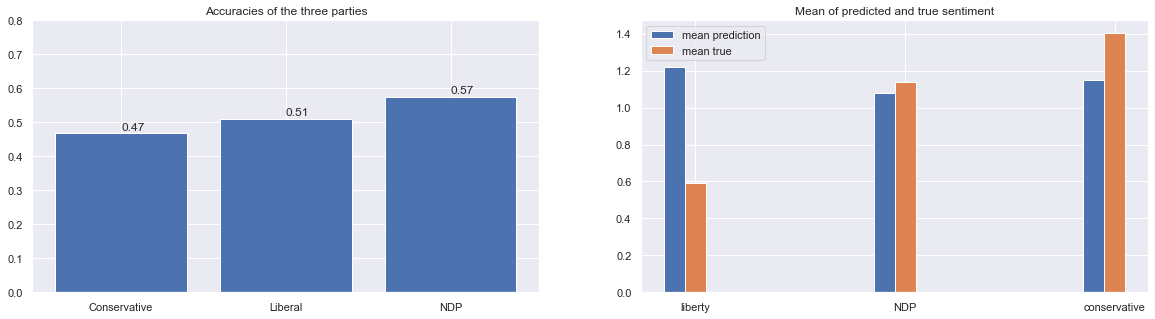

In [46]:
report = {}
for party in election_df['party'].unique():
    if party == "None": continue
    print(party)
    df = election_df[election_df['party']==party]
    election_X, election_y = df['text'].values, df['sentiment'].values
    election_X = vectorizer_wf.transform(election_X).toarray()
    y_true, y_pred = election_y, clf41.predict(election_X)
    report[party] = classification_report(y_true, y_pred, output_dict=True)
    report[party]['mean-pred'] = np.mean(y_pred) + 1
    report[party]['mean-true'] = np.mean(y_true) + 1
    print(classification_report(y_true, y_pred))
    
parties = list(report.keys())

# visualize
fig, axes = plt.subplots(1, 2, figsize=(20,5))
accs = [report[p]['accuracy'] for p in parties]
x = range(len(parties))
axes[0].set_title("Accuracies of the three parties")
axes[0].bar(x, accs)
axes[0].set_xticks(x)
axes[0].set_xticklabels(parties)
axes[0].set_ylim(0, 0.8)
for i, v in enumerate(accs):
    axes[0].text(i, v+0.01, '%.2f'%(v))

x = np.arange(len(parties))
width = 0.1
axes[1].bar(x - 0.1, [report[p]['mean-pred'] for p in parties], width, label='mean prediction')
axes[1].bar(x, [report[p]['mean-true'] for p in parties], width, label='mean true')
axes[1].set_title('Mean of predicted and true sentiment')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['liberty', 'NDP', 'conservative'])
axes[1].legend()
plt.show()

#### 4.9 Predict negative reason for negative 2019 Canadian elections
Since **Healthcare and Marijuana** and **Healthcare** are similar and they are all in small proportion. Therefore, we are going to merge them together. For 9 class muti-classifier, **Random Forest** has the best performance, which reaches the accuracy of **55%**

In [68]:
negative_election_df = election_df[election_df['sentiment']==-1]
negative_election_df = negative_election_df[negative_election_df['negative_reason'].notna()]
negative_reasons = negative_election_df['negative_reason'].unique()
print(negative_reasons)
print(negative_election_df.shape)

['Women Reproductive right and Racism' 'Economy' 'Others' 'Scandal'
 'Tell lies' 'Privilege' 'Climate Problem' 'Healthcare' 'Separation'
 'Healthcare and Marijuana']
(1006, 5)


In [69]:
reasons_dict = { 
    'Women Reproductive right and Racism': 0,
    'Economy': 1,
    'Others': 2,
    'Scandal': 3, 
    'Tell lies': 4,
    'Privilege': 5,
    'Climate Problem': 6,
    'Separation': 7,
    'Healthcare': 8,
    'Healthcare and Marijuana': 8
}
negative_election_df['negative_reason'] = negative_election_df['negative_reason'].apply(lambda x:reasons_dict[x])

columns = ['text', 'negative_reason']
negative_election_train, negative_election_test = \
train_test_split(negative_election_df[columns].values, test_size=0.3, random_state=42)

negative_election_train_X, negative_election_train_y = negative_election_train[:,[0]].flatten(), negative_election_train[:,[1]].flatten().astype('int')
negative_election_test_X, negative_election_test_y = negative_election_test[:, [0]].flatten(), negative_election_test[:,[1]].flatten().astype('int')

vectorizer_wf = CountVectorizer(max_features=200)
negative_election_train_X = vectorizer_wf.fit_transform(negative_election_train_X).toarray()
# print(vectorizer_wf.vocabulary_)
print(vectorizer_wf.get_feature_names()[:50])
print(negative_election_train_X.shape)

negative_election_test_X = vectorizer_wf.transform(negative_election_test_X).toarray()
print(negative_election_test_X.shape)

['ableg', 'abort', 'alberta', 'also', 'american', 'andi', 'andrew', 'andrewscheer', 'anoth', 'answer', 'ask', 'attack', 'away', 'back', 'bad', 'believ', 'bernier', 'big', 'call', 'campaign', 'canada', 'canadavotes2019', 'canadian', 'candid', 'care', 'cbc', 'cbckatie', 'cdnelxn2019', 'cdnmedia', 'cdnpoli', 'chooseforward', 'climat', 'cndpoli', 'come', 'comment', 'con', 'conserv', 'consult', 'corrupt', 'could', 'countri', 'cpc', 'cpc_hq', 'day', 'debat', 'deserv', 'desper', 'destroy', 'dirti', 'done']
(704, 200)
(302, 200)


In [70]:
# Train with Linear SVC
print(negative_election_train_y.shape)
print(negative_election_train_X.shape)
clf1 = LinearSVC()
clf1.fit(negative_election_train_X, negative_election_train_y)
y_true, y_pred = negative_election_test_y, clf1.predict(negative_election_test_X)
print(classification_report(y_true, y_pred))

(704,)
(704, 200)
              precision    recall  f1-score   support

           0       0.25      0.25      0.25         8
           1       0.25      0.40      0.31        10
           2       0.56      0.63      0.60       119
           3       0.53      0.53      0.53        73
           4       0.60      0.53      0.56        64
           5       0.00      0.00      0.00         3
           6       0.70      0.37      0.48        19
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2

    accuracy                           0.53       302
   macro avg       0.32      0.30      0.30       302
weighted avg       0.54      0.53      0.53       302



In [71]:
# Train with Naive Bayes
clf2 = GaussianNB()
clf2.fit(negative_election_train_X, negative_election_train_y)
y_true, y_pred = negative_election_test_y, clf2.predict(negative_election_test_X)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.05      0.25      0.09         8
           1       0.06      0.20      0.09        10
           2       0.52      0.29      0.38       119
           3       0.50      0.41      0.45        73
           4       0.40      0.45      0.42        64
           5       0.00      0.00      0.00         3
           6       0.12      0.05      0.07        19
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2

    accuracy                           0.33       302
   macro avg       0.18      0.18      0.17       302
weighted avg       0.42      0.33      0.36       302



In [72]:
# Train with Random forest
clf3 = RandomForestClassifier(max_depth=4)
clf3.fit(negative_election_train_X, negative_election_train_y)
y_true, y_pred = negative_election_test_y, clf3.predict(negative_election_test_X)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        10
           2       0.48      0.92      0.63       119
           3       0.73      0.37      0.49        73
           4       0.78      0.45      0.57        64
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2

    accuracy                           0.55       302
   macro avg       0.22      0.19      0.19       302
weighted avg       0.53      0.55      0.49       302



### 5. Results
* Among the three parties, Liberal has the most positive sentiment compared with other parties. While most of the people talk about conservative in the dataset.
* The reasons why the second model fail to predict the correct negative reasons are:
    * The distributions of each negative reason is different. The higher proportion of data have, the better performance we could reach.
    * Some negative reasons are similar.
    * The training set is not enough, only 700, could result in overfitting.
* Suggestions to improve the first model:
    * Use deep learning model and word-embedding to predict the sentiment analysis
    * Accumulate more features of twitter, including usernames, date, etc.
* Suggestions to improve the second model:
    * Add more data.
    * Use deep leanring model and word-embedding to predict the sentiment analysis

### Bonus: LSTM with Word Embedding
We are going to train the LSTM word embedding. The dataset we chose is the 2019 Canadian Election Datasets.

In [106]:
columns = ['text', 'negative_reason']
negative_election_train, negative_election_test = \
train_test_split(negative_election_df[columns].values, test_size=0.3, random_state=42)

negative_election_train_X, negative_election_train_y = negative_election_train[:,[0]].flatten(), negative_election_train[:,[1]].flatten().astype('int')
negative_election_test_X, negative_election_test_y = negative_election_test[:, [0]].flatten(), negative_election_test[:,[1]].flatten().astype('int')
print(negative_election_train_X.shape, negative_election_train_y.shape)
print(negative_election_test_X.shape, negative_election_test_y.shape)

(704,) (704,)
(302,) (302,)


In [107]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

In [111]:
from keras.utils import to_categorical

corpus = ' '.join(negative_election_train_X)
vab = list(set(corpus))
vab_rev = collections.defaultdict(int)
for ind, word in enumerate(vab):
    vab_rev[word] = ind+1
X_train, X_test = [], []
for line in negative_election_train_X:
    X_train.append(list(map(lambda x:vob_rev[x], [word for word in line.split(' ')])))
for line in negative_election_test_X:
    X_test.append(list(map(lambda x:vob_rev[x], [word for word in line.split(' ')])))
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

y_train, y_test = negative_election_train_y, negative_election_test_y
# y_train, y_test = to_categorical(negative_election_train_y, num_classes=9), to_categorical(negative_election_test_y, num_classes=9)

In [113]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(100, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 500, 32)           3200      
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 56,501
Trainable params: 56,501
Non-trainable params: 0
_________________________________________________________________
None
Train on 704 samples, validate on 302 samples
Epoch 1/20
704/704 [==============================] - 9s 12ms/step - loss: -11.5798 - accuracy: 0.0582 - val_loss: -25.5993 - val_accuracy: 0.0331
Epoch 2/20
704/704 [==============================] - 8s 12ms/step - loss: -28.7821 - accuracy: 0.0582 - val_loss: -37.1147 - val_accuracy: 0.0331
Epoch 3/20
704/704 [==============